# Analysis of ABCtoolbox results

ABCtoolbox output includes:  
- retained simulations
- marginal posterior densities
- marginal posterior densities charecterisitcs
- joint posterior densities

In this Notebook, I:
- reformat the marginal posterior densities charecterisitcs file so it is easily readable
- plot a heatmap of the joint posterior densities
- calculate the probability NEA > NWA
- plot the marginal priors, truncated priors, and posterior denstities

## Setup code

In [2]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/opt/anaconda3/bin/python
3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)


In [3]:
%%bash
# sudo /opt/anaconda3/bin/conda install rpy2
# sudo /opt/anaconda3/bin/conda install -c conda-forge ggplot

In [4]:
from sys import argv
import os
import pandas as pd
# from ggplot import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True, style="ticks")
import numpy as np
# import rpy2
# %load_ext rpy2.ipython

## Functions

In [11]:
def read_abc_config(abc_config_name):
    """
    Get input files used for ABC and results files output by ABC.
    :param abc_config_name: The configuration file used to run ABCtoolbox 
    :return: simName:
    :return: obsName:
    :return: outputPrefix:
    """

    simName = ""
    obsName = ""
    outputPrefix = ""

    if os.path.isfile(abc_config_name):
        print(abc_config_name)
        abc_config = open(abc_config_name, 'r')
        for line in abc_config:
            line_lst = line.split()
            arg = line_lst[0]
            if arg == "simName":
                simName = line.split()[1]
            if arg == "obsName":
                obsName = line.split()[1]
            if arg == "outputPrefix":
                outputPrefix = line.split()[1]
            if arg == "params":
                params_str = line.split()[1]
        abc_config.close()
    else:
        print('{} does not exist'.format(abc_config_name))
        exit()

    if not simName:
        print("simName not included in ABCtoolbox config file")
        exit()
    if not obsName:
        print("obsName not included in ABCtoolbox config file")
        exit()
    if not outputPrefix:
        print("outputPrefix not included in ABCtoolbox config file")
        exit()

    return [simName, obsName, outputPrefix, params_str]


def get_results_files(outputPrefix):
    """
    Define names of ABCtoolbox estimate results files
    :param outputPrefix: the output prefix provided in the ABCtoolbox config file
    :return: names of ABCtoolbox output files
    """

    BestSimsParamStats_name = '{}model0_BestSimsParamStats_Obs0.txt'.format(outputPrefix)
    MarginalPosteriorDensities_name = '{}model0_MarginalPosteriorDensities_Obs0.txt'.format(outputPrefix)
    MarginalPosteriorCharacteristics_name = '{}model0_MarginalPosteriorCharacteristics.txt'.format(outputPrefix)
    jointPosterior_name = '{}model0_jointPosterior_8_9_Obs0.txt'.format(outputPrefix)
    MarginalPosteriorCharacteristics_reformat_name = '{}model0_MarginalPosteriorCharacteristicsReformat.txt'.format(outputPrefix)
    modelFit_name = '{}modelFit.txt'.format(outputPrefix)

    
    return [BestSimsParamStats_name,
            MarginalPosteriorDensities_name,
            MarginalPosteriorCharacteristics_name,
            jointPosterior_name,
            MarginalPosteriorCharacteristics_reformat_name,
           modelFit_name]


def get_modelchocie_files(outputPrefix):
    """
    Define names of ABCtoolbox model choice
    :param outputPrefix: the output prefix provided in the ABCtoolbox config file
    :return: names of ABCtoolbox output files
    """
    
    confusionMatrix_name = '{}confusionMatrix.txt'.format(outputPrefix)
    modelChoiceValidation_name = '{}modelChoiceValidation.txt'.format(outputPrefix)
    modelFit_name = '{}modelFit.txt'.format(outputPrefix)
    
    return [confusionMatrix_name,
           modelChoiceValidation_name,
           modelFit_name]
    

def reformat_Characteristics(MarginalPosteriorCharacteristics_name):
    """
    reformat the ABCtoolbox output file MarginalPosteriorCharacteristics to a table with parameter as the rows and
     posterior density characteristics as columns.
    :param MarginalPosteriorCharacteristics_name: file name of ABCtoolbox output file with characteristics of posterior
    density.
    :return: df_table: pandas dataframe with parameters as rows and posterior density characteristics as columns
    """

    characteristics = ['mode', 'mean', 'median', 'q50_lower', 'q50_upper', 'q90_lower', 'q90_upper', 'q95_lower', 'q95_upper',
                  'q99_lower', 'q99_upper', 'HDI50_lower', 'HDI50_upper', 'HDI90_lower', 'HDI90_upper', 'HDI95_lower',
                  'HDI95_upper', 'HDI99_lower', 'HDI99_upper']
    n_chars = len(characteristics)

    if os.path.isfile(MarginalPosteriorCharacteristics_name):
        print('parsing {}'.format(MarginalPosteriorCharacteristics_name))

        df = pd.read_csv(MarginalPosteriorCharacteristics_name, sep = '\t').drop('dataSet', 1)
        header = list(df)

        df_list = []
        start = 0
        for i in range(1, int(len(df.columns)/n_chars)):
            param = header[start].split(characteristics[0])[0].strip('_')
            df_param = df.loc[:, header[start]:header[start + n_chars - 1]]
            df_param.columns = characteristics
            df_param['param'] = param
            df_param.set_index('param')
            df_list.append(df_param)
            start = n_chars * i
        df_table = pd.concat(df_list)

    else:
        print('{} does not exist'.format(MarginalPosteriorCharacteristics_name))
        print('Did you run ABCtoolbox in this directory?')
        exit()

    return df_table


def get_param_indexes(params_str):
    """
    Convert string of parameter column numbers into list of ints
    :param params_str: string of parameter column numbers from the ABCtoolbox config file, of the form: 1-5,9-12
    :return: get_param_indexes: list of ints
    """
    param_indexes = []
    ranges = params_str.split(',')
    for values in ranges:
        x = int(values.split('-')[0].strip()) - 1
        y = int(values.split('-')[1].strip())
        param_indexes.extend(list(range(x, y)))
    return param_indexes


def get_col_names(ints, df):
    """
    Get list of column names of a dataframe from list of ints
    :param ints: list of integers
    :param df: dataframe with column names
    :return: names: list of column names
    """
    
    names = []
    for i in ints:
        names.append(list(df)[i])
    return names


def plot_param_densities(posterior, truncated, prior, param):
    """
    Use matplotlib and seaborn to plot prior, truncated, and posterior distributions of parameter.
    :param posterior: dataframe of ABCtoolbox *MarginalPosteriorDensities_Obs0.txt
    :param truncated: dataframe of ABCtoolbox *BestSimsParamStats_Obs0.txt
    :param prior: dataframe of simulation input for ABCtoolbox
    :param param: string parameter name, which is the column name in the dataframes
    """
    plt.figure()
    plt.xlabel(param);
    plt.plot(posterior[param], posterior['{}.density'.format(param)], label = 'posterior');
    sns.kdeplot(truncated[param], label = 'truncated prior');
    sns.kdeplot(prior[param], color = 'grey', label = 'prior');
    return


def create_joint_df(jointPosterior_name):

    if os.path.isfile(jointPosterior_name):
        joint_NEA_NWA_df = pd.read_csv(jointPosterior_name, sep = '\t')
    else:
        print('{} does not exist'.format(jointPosterior_name))
        print('Did you run ABCtoolbox in this directory?')
        exit()
    return joint_NEA_NWA_df


def get_prob_NEA_grtr_NWA(joint_NEA_NWA_df):
    total_density = sum(joint_NEA_NWA_df['density'])
    NEA_grtr_density = joint_NEA_NWA_df[joint_NEA_NWA_df['Log10_NEA'] > joint_NEA_NWA_df['Log10_NWA']]['density']
    prob = sum(NEA_grtr_density)/total_density
    return prob


def plot_joint_mtpltlb(joint_NEA_NWA_df, df_chrs_reformat):

    # density map
    NWA, NEA, z = joint_NEA_NWA_df['Log10_NWA'], joint_NEA_NWA_df['Log10_NEA'], joint_NEA_NWA_df['density']
    NWA = np.unique(NWA)
    NEA = np.unique(NEA)
    X, Y = np.meshgrid(NWA, NEA)
    Z = z.reshape(len(NEA), len(NWA))
    plt.pcolormesh(X, Y, Z, cmap='viridis')
    colorbar = plt.colorbar()
    colorbar.set_label('Density')

    # y = x line
    plt.plot(NWA, NWA, color='black')

    # Scatterplot point
    NEA_mode = df_chrs_reformat.loc[df_chrs_reformat['param'] == 'Log10_NEA']['mode']
    NWA_mode = df_chrs_reformat.loc[df_chrs_reformat['param'] == 'Log10_NWA']['mode']
    plt.scatter(NWA_mode, NEA_mode, marker='*', facecolor='black', edgecolor='none')

    # Axes limits and labels
    plt.xlim(np.min(NWA), np.max(NWA))
    plt.xlabel('$\log_{10}$ NWA')

    plt.ylabel('$\log_{10}$ NEA')
    plt.ylim(min(NEA), max(NEA))
    plt.show()
    return

## Create PCA and density plots of summary statistics

In [ ]:
%%bash
if [ -e "/mnt/ABC_AJmodels_genome_newreal/input_ABC_HPC_OSG_CHTC_2_pca.pdf" ]; then
    echo "File exists"
else 
    head -1 /mnt/ABC_AJmodels_genome_newreal/input_ABC_HPC_OSG_CHTC_2.txt >/mnt/ABC_AJmodels_genome_newreal/header_M2.txt
    Rscript /mnt/src/macsswig_simsaj/dist_plot_stats.R mnt/ABC_AJmodels_genome_newreal/input_ABC_HPC_OSG_CHTC_2.txt /mnt/ABC_AJmodels_genome_newreal/real_output_M23_IBD.txt /mnt/ABC_AJmodels_genome_newreal/header_M2.txt
fi 

In [ ]:
%%bash
ls /mnt/ABC_AJmodels_genome_newreal/*pdf

## Correlated Stats Pruned

### Model 2

In [ ]:
path = '/mnt/ABC_AJmodels_genome_newreal'
os.chdir(path)
abc_config_name = "test_ABC_estimate.txt"

[simName, obsName, outputPrefix, params_str] = read_abc_config(abc_config_name)
print(simName)

[BestSimsParamStats_name,
 MarginalPosteriorDensities_name,
 MarginalPosteriorCharacteristics_name,
 jointPosterior_name,
 MarginalPosteriorCharacteristics_reformat_name,
modelFit_name] = get_results_files(outputPrefix)
print(BestSimsParamStats_name)
print(MarginalPosteriorDensities_name)
print(jointPosterior_name)
print(MarginalPosteriorCharacteristics_reformat_name)
print(modelFit_name)

#### Reformat marginal posterior densities charecterisitcs file

In [ ]:
df_chrs_reformat = reformat_Characteristics(MarginalPosteriorCharacteristics_name)
df_chrs_reformat

#### Priors, truncated, and posterior distributions

In [ ]:
prior = pd.read_csv(simName, sep = '\t')
prior.head()

In [ ]:
truncated = pd.read_csv(BestSimsParamStats_name, sep = '\t')
truncated.head()

In [ ]:
posterior = pd.read_csv(MarginalPosteriorDensities_name, sep = '\t')
posterior.head()

In [ ]:
param_indexes = get_param_indexes(params_str)
params = get_col_names(param_indexes, prior)

In [ ]:
for param in params:
    plot_param_densities(posterior, truncated, prior, param)

#### Joint density plot

Create joint density dataframe

In [ ]:
joint_NEA_NWA_df = create_joint_df(jointPosterior_name)
joint_NEA_NWA_df.head()

In [ ]:
prob = get_prob_NEA_grtr_NWA(joint_NEA_NWA_df)
print(prob)

In [ ]:
plot_joint_mtpltlb(joint_NEA_NWA_df, df_chrs_reformat)

## PLS
data and results in `/mnt/ABC_AJmodels_genome_newreal/PLS`

In [13]:
path = '/mnt/ABC_AJmodels_genome_newreal/PLS'
os.chdir(path)
abc_config_name = "test_ABC_estimate_PLS.txt"

[simName, obsName, outputPrefix, params_str] = read_abc_config(abc_config_name)
print(simName)

[BestSimsParamStats_name,
 MarginalPosteriorDensities_name,
 MarginalPosteriorCharacteristics_name,
 jointPosterior_name,
 MarginalPosteriorCharacteristics_reformat_name,
modelFit_name] = get_results_files(outputPrefix)
print(BestSimsParamStats_name)
print(MarginalPosteriorDensities_name)
print(jointPosterior_name)
print(MarginalPosteriorCharacteristics_reformat_name)

test_ABC_estimate_PLS.txt
input_ABC_HPC_OSG_CHTC_2_transformed_10pls.txt
ABC_M2_genome_estimate_96334_10pls_1000ret_model0_BestSimsParamStats_Obs0.txt
ABC_M2_genome_estimate_96334_10pls_1000ret_model0_MarginalPosteriorDensities_Obs0.txt
ABC_M2_genome_estimate_96334_10pls_1000ret_model0_jointPosterior_8_9_Obs0.txt
ABC_M2_genome_estimate_96334_10pls_1000ret_model0_MarginalPosteriorCharacteristicsReformat.txt


#### Reformat marginal posterior densities charecterisitcs file

In [15]:
df_chrs_reformat = reformat_Characteristics(MarginalPosteriorCharacteristics_name)
df_chrs_reformat

parsing ABC_M2_genome_estimate_96334_10pls_1000ret_model0_MarginalPosteriorCharacteristics.txt


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,mode,mean,median,q50_lower,q50_upper,q90_lower,q90_upper,q95_lower,q95_upper,q99_lower,q99_upper,HDI50_lower,HDI50_upper,HDI90_lower,HDI90_upper,HDI95_lower,HDI95_upper,HDI99_lower,HDI99_upper,param
0,18.363600,14.665200,15.168800,12.585700,17.702200,6.322070,19.480000,4.964500,19.729200,3.218940,19.943600,14.908300,19.727300,9.257390,20.000000,6.322070,20.000000,3.829220,20.000000,Asc_NAF
0,3.090910,9.711350,9.954250,5.117520,13.972900,2.618170,17.355000,2.314680,18.295600,2.064430,19.514700,2.000000,9.954250,2.000000,16.144300,2.000000,17.355000,2.000000,19.134600,Asc_NEU
0,5.090910,6.558800,5.933600,4.109110,8.113250,2.493160,13.980000,2.255380,15.592800,2.052910,17.987000,3.049940,6.818180,2.000000,11.336800,2.000000,13.980000,2.000000,17.116900,Asc_NCHB
0,0.093434,0.091075,0.091684,0.087299,0.095603,0.080442,0.099009,0.077655,0.099492,0.070549,0.099895,0.089646,0.097672,0.083181,0.099999,0.080442,0.099999,0.073651,0.099999,daf
0,4.724240,4.553040,4.578020,4.387290,4.748990,4.098940,4.910290,4.012990,4.945480,3.840330,4.986050,4.474150,4.822720,4.166160,4.954670,4.093100,4.993420,3.908590,4.999990,Log10_NAF
0,4.797980,4.656780,4.706530,4.519460,4.842100,4.150320,4.961510,4.039000,4.979940,3.830730,4.995790,4.665550,4.949490,4.290420,5.000000,4.150320,5.000000,3.915500,5.000000,Log10_NCEU
0,3.707070,3.763640,3.746830,3.611440,3.901080,3.432100,4.152210,3.375390,4.232170,3.264710,4.384040,3.575750,3.860570,3.414140,4.129980,3.353530,4.207190,3.252520,4.369530,Log10_NCHB
0,5.840450,5.181880,5.258350,4.510460,5.890420,3.718350,6.428830,3.483400,6.542990,3.159400,6.663040,4.979430,6.307560,3.914530,6.569140,3.699470,6.681250,3.266590,6.699930,Log10_NWA
0,6.318170,5.620110,5.840050,5.024820,6.277670,4.188280,6.575550,4.100630,6.630260,4.021900,6.684040,5.803210,6.659070,4.342240,6.686340,4.188280,6.699980,4.042810,6.699980,Log10_NEA
0,3.393740,3.417830,3.413510,3.074240,3.755990,2.618020,4.230330,2.479380,4.382290,2.230960,4.690280,3.060740,3.742170,2.594970,4.206750,2.443360,4.346120,2.209060,4.660700,Log10_NAg


#### Priors, truncated, and posterior distributions

In [16]:
prior_pls = pd.read_csv(simName, sep = '\t')
prior_pls.head()

,sim,Asc_NAF,Asc_NEU,Asc_NCHB,daf,Log10_NAF,Log10_NANC,Log10_NCEU,Log10_NCHB,Log10_NWA,...,LinearCombination_0,LinearCombination_1,LinearCombination_2,LinearCombination_3,LinearCombination_4,LinearCombination_5,LinearCombination_6,LinearCombination_7,LinearCombination_8,LinearCombination_9
0,1027430.0,18,15,17,0.063976,4.07809,3.80195,3.35102,4.51846,5.00670,...,-3.24385,-2.92342,-2.12947,-2.575080,1.12293,0.956623,0.615963,-0.942135,-1.29454,0.678204
1,1027430.0,16,20,8,0.074399,4.75215,4.02309,4.96067,4.28513,5.05156,...,-10.32210,7.78496,-2.73008,-3.513680,-1.98929,1.432610,-0.763788,2.076480,-2.76173,0.469587
2,1027430.0,11,13,8,0.060090,4.52791,4.39340,4.61965,4.70173,5.03003,...,13.42980,10.68570,4.45857,0.487421,4.84201,-4.931780,-2.188600,-2.454990,2.11956,-0.369664
3,1027430.0,13,7,5,0.077346,4.03997,4.01229,3.68124,3.17348,3.55437,...,10.61930,-4.29706,2.54018,-0.158184,3.88781,1.448610,4.165740,2.296540,2.47995,0.026251
4,1027430.0,13,17,9,0.077928,4.54010,4.52481,3.12840,3.36436,5.45016,...,-19.95690,-2.82774,-1.02644,-4.407730,-2.53827,2.839090,2.780910,-1.218650,3.58499,-0.407411


In [17]:
truncated_pls = pd.read_csv(BestSimsParamStats_name, sep = '\t')
truncated_pls.head()

,Sim_num,Dist,Asc_NAF,Asc_NEU,Asc_NCHB,daf,Log10_NAF,Log10_NCEU,Log10_NCHB,Log10_NWA,...,LinearCombination_0,LinearCombination_1,LinearCombination_2,LinearCombination_3,LinearCombination_4,LinearCombination_5,LinearCombination_6,LinearCombination_7,LinearCombination_8,LinearCombination_9
0,32,11.9767,5,5,5,0.068311,4.60141,3.83803,3.72542,5.13338,...,-14.1509,1.58473,-2.70297,-4.76552,-3.03661,3.96135,3.351960,1.64289,-0.240781,-1.024150
1,44,30.9672,17,3,12,0.094569,4.13293,4.43685,4.34044,6.32371,...,-8.4300,1.28672,-3.92734,-1.90704,-1.30004,2.79232,3.271970,2.59049,-1.857660,-1.593530
2,99,32.2504,17,16,10,0.096923,4.41180,4.54911,4.06100,4.29909,...,-14.0772,1.54763,-3.30219,-2.77118,-2.71928,1.39698,0.123887,1.51073,-0.601559,-1.453430
3,115,20.4209,5,5,6,0.090136,4.37842,4.72775,3.68043,6.13776,...,-14.6503,4.31167,-2.80982,-4.67220,-3.41754,3.35661,1.807860,2.14078,-0.793186,-1.059040
4,124,25.0922,19,7,9,0.087624,4.39801,4.99303,3.92778,3.64758,...,-12.3235,2.37149,-5.23194,-2.20384,-2.75268,2.16104,1.284960,3.14721,-2.177180,0.267372


In [18]:
posterior_pls = pd.read_csv(MarginalPosteriorDensities_name, sep = '\t')
posterior_pls.head()

,number,Asc_NAF,Asc_NAF.density,Asc_NEU,Asc_NEU.density,Asc_NCHB,Asc_NCHB.density,daf,daf.density,Log10_NAF,...,Teu_as,Teu_as.density,TA,TA.density,TMJ,TMJ.density,TAEW,TAEW.density,Tm,Tm.density
0,1,2.00000,0.002190,2.00000,0.077599,2.00000,0.094509,0.050000,0.005047,3.70001,...,404.000,0.001276,20.0000,0.016799,21.000,0.002996,2.00000,0.013878,3.00000,0.005285
1,2,2.18182,0.002638,2.18182,0.079860,2.18182,0.099761,0.050505,0.006200,3.71314,...,441.293,0.001322,20.1616,0.017715,32.899,0.003078,2.32323,0.014772,3.32323,0.005793
2,3,2.36364,0.003152,2.36364,0.081656,2.36364,0.104744,0.051010,0.007558,3.72627,...,478.586,0.001358,20.3232,0.018603,44.798,0.003137,2.64646,0.015665,3.64646,0.006297
3,4,2.54545,0.003739,2.54545,0.082989,2.54545,0.109416,0.051515,0.009145,3.73940,...,515.879,0.001382,20.4848,0.019462,56.697,0.003172,2.96970,0.016562,3.96970,0.006792
4,5,2.72727,0.004399,2.72727,0.083873,2.72727,0.113750,0.052020,0.010986,3.75253,...,553.172,0.001395,20.6465,0.020292,68.596,0.003183,3.29293,0.017467,4.29293,0.007270


In [19]:
param_indexes = get_param_indexes(params_str)
params = get_col_names(param_indexes, prior_pls)

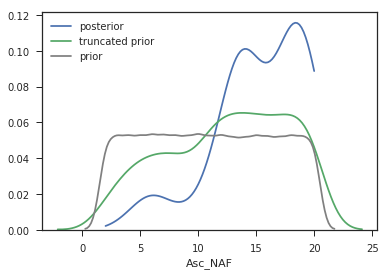

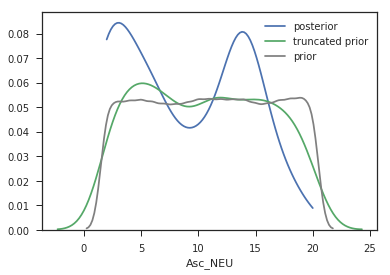

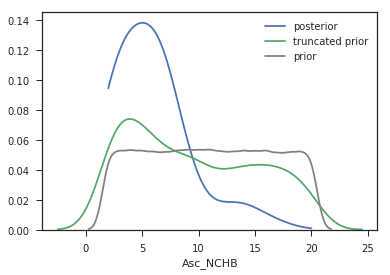

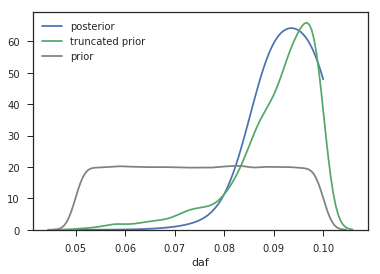

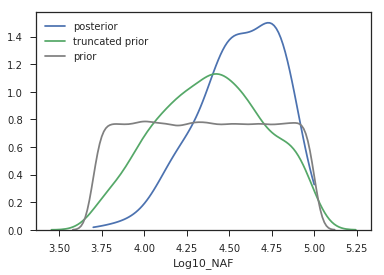

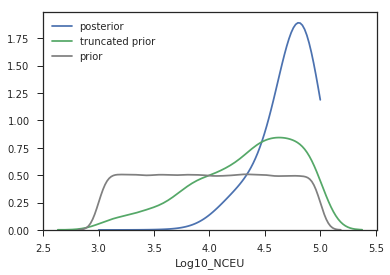

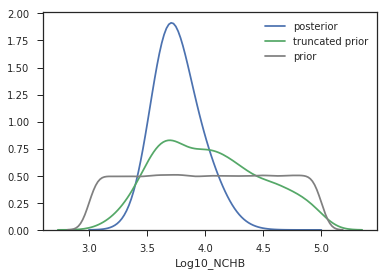

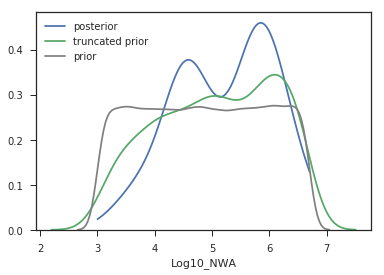

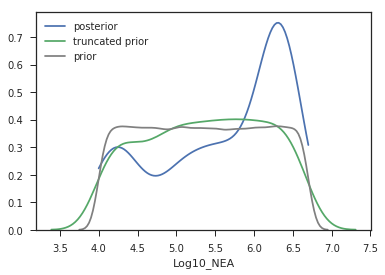

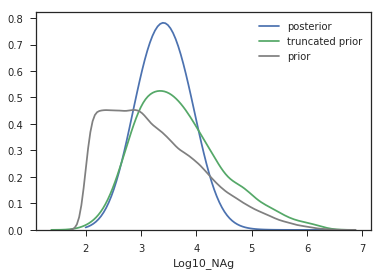

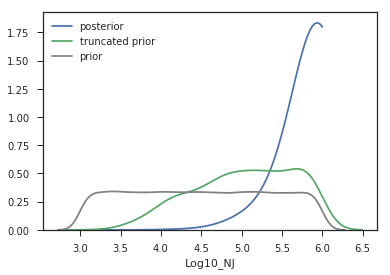

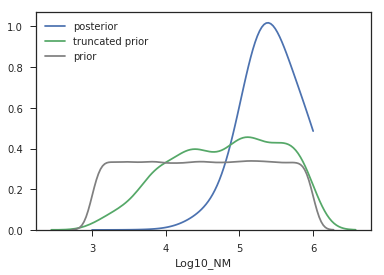

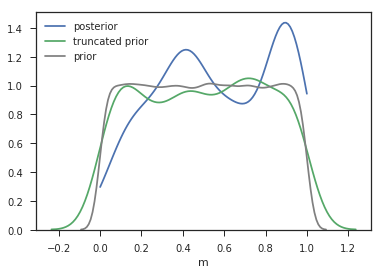

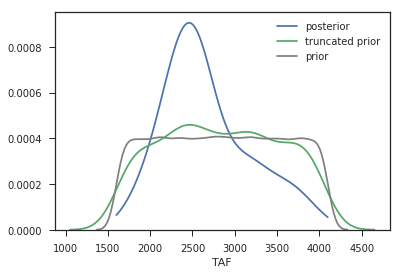

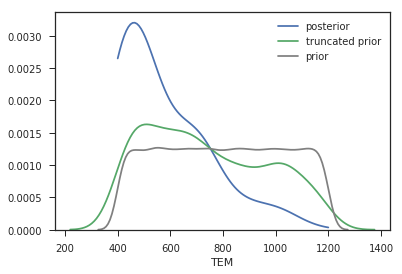

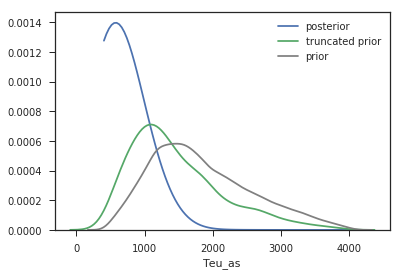

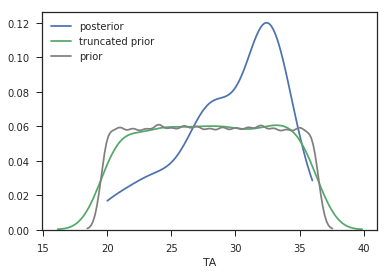

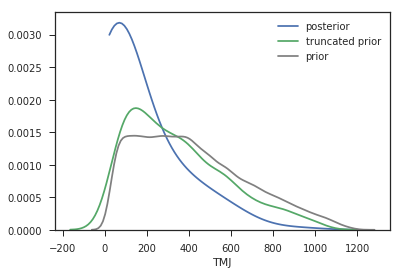

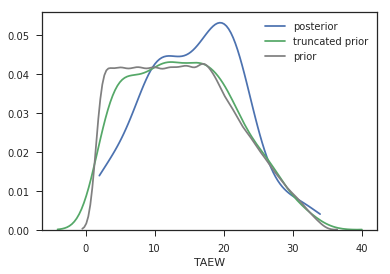

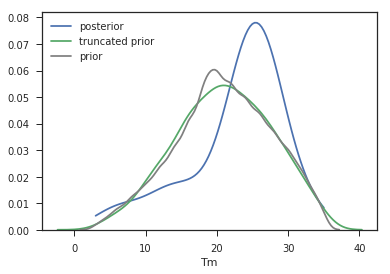

In [20]:
for param in params:
    plot_param_densities(posterior_pls, truncated_pls, prior_pls, param)

#### Joint density plot

Create joint density dataframe

In [21]:
joint_NEA_NWA_df_pls = create_joint_df(jointPosterior_name)
joint_NEA_NWA_df_pls.head()

,number,Log10_NWA,Log10_NEA,density,HDI
0,0,3.00043,4.00004,0.557281,0.999800
1,1,3.03780,4.00004,0.609844,0.999625
2,2,3.07517,4.00004,0.662231,0.999403
3,3,3.11254,4.00004,0.713823,0.999196
4,4,3.14990,4.00004,0.764061,0.998909


In [22]:
prob = get_prob_NEA_grtr_NWA(joint_NEA_NWA_df_pls)
print(prob)

0.6382405627050782


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:195: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


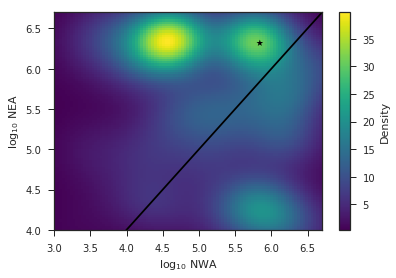

In [23]:
plot_joint_mtpltlb(joint_NEA_NWA_df_pls, df_chrs_reformat)